# CNN Building Process
    
    基于TensorFlow构建指定的网络结构
    这里使用卷积神经网络，是为了综合上下文信息，给出一句话中每个单词（token）对应的标签（tags）概率分布。使用CNN分析单词附近的文本,将在顶部使用密集层进行标签分类

## 预备知识
    
    1.环境：Tensorflow-gpu 的安装、配置（cuda，cudnn）以及使用，unfinished
    2.深度学习、CNN相关知识，嫉妒欠缺！！！
    3.Dataset的准备（之前所做）

In [1]:
import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.set_random_seed(42)

/home/zhl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


    几乎所有的自然语言处理网络结构都拥有一个必不可少的部分——单词嵌入。我们将文本分解为一系列tokens传入网络当中，每一个token又由他们的数字索引进行表示。每一个token（索引），都拥有一个向量，所有的向量形成嵌入矩阵（embedding matrix）。该矩阵可以使用一些常用算法（如Skip-Gram或CBOW）进行预训练，也可以通过随机值进行初始化，并与网络的其他参数一起进行训练。 在本教程中，我们将遵循第二种选择。
    
    我们下面需要构建一个函数，其采用[batch_size, num_tokens]形状的标记索引的张量，并且对于这个矩阵中的每个索引，它从嵌入矩阵中检索对应于该索引的张量。这会产生一个新的张量，形状为[batch_size,num_tokens,emb_dim]。

In [2]:
def get_embeddings(indices, vocabulary_size, emb_dim):
    # Initialize the random gaussian matrix with dimensions [vocabulary_size, embedding_dimension]
    # np.random.randn()初始化一个矩阵，形状为[vocabulary_size, embedding_dimension]，内部元素服从标准高斯分布，类型为np.float32
    # The **VARIANCE** of the random samples must be 1 / embedding_dimension
    # 随机样本的方差是 1/embedding_dimension??
    #np.random.randn()返回一组符合指定维度的样本方差为1(标准正态分布),这里是词嵌入矩阵,列数代表词向量的维度,行数代表词的个数,输入的独热向量代表id,根据词的下标选择矩阵中对应行,对应一个词向量,获得的方差为1/emb_dim
    emb_mat = np.random.randn(vocabulary_size, emb_dim).astype(np.float32) / np.sqrt(emb_dim) 
    
    # 构造一个能用Tensorflow计算的变量 ↓
    # 参考 http://www.cnblogs.com/nowornever-L/p/6908775.html
    emb_mat = tf.Variable(emb_mat, name='Embeddings', trainable=True)
    
    # 在emb_mat中检索indices所表示的内容
    emb = tf.nn.embedding_lookup(emb_mat, indices)
    return emb

    神经网络的主体是卷积层(convolutional layers)，即对每n个连续tokens，应用相同的全连接层(dense layer)。
    
    致密层是指每个神经元从前一层的所有神经元获得输入进而实现密集连接。层应该拥有一个权重矩阵 W 和一个偏差矩阵 b。
    致密层就像是实现了矩阵的乘法。
    
    简化情况如下。

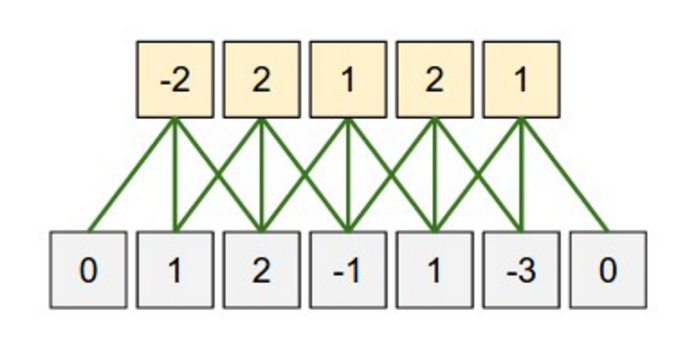


In [3]:
import tensorflow as tf

# Create a tensor with shape [batch_size, number_of_tokens, number_of_features]
x = tf.random_normal(shape=[2, 10, 100]) # 输入矩阵，由服从标准正态分布的数值填充.矩阵的长为2,宽为10,每一个元素为长度为100的词向量
#这里的长为之前处理的每次选取的句子数目,宽为每一个句子最长的单词数,假定10,batch_size代表选取了多少个句子,number_of_tokens代表一个句子选
#取了多少个单词(按最长的取),number_of_features对应一个单词的向量长度也是特征数

# 生成卷积核，filter对应的是卷积核的数目和输出的特征数目.kernel对应的是卷积核的长度(默认宽度为1),默认步长为1
#卷积核与输入矩阵进行卷积运算,得到一个长度为3(10-8+1),宽度为2的特征矩阵,矩阵的每一个元素为一个特征值(注意:卷积核的每一个元素也是长度为100的
#向量,卷积运算后每一个矩阵元素为一个数值)
#对于200个卷积核,产生200个这样的矩阵,200个特征元素对应合并,产生输出
y = tf.layers.conv1d(x, filters=200, kernel_size=8)
print(y) # Tensor("conv1d/BiasAdd:0", shape=(2, 3, 200), dtype=float32)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(y))
#print(sess.run(x))

# 因为输出的矩阵和输入的矩阵维数不一致,这里主要是列数不一样,所以在输入的列的左右两边均匀填充0,使得指定步长输出的矩阵维数和输入相同,如果左右两边填充的0不一样,多的在右边
y_with_padding = tf.layers.conv1d(x, filters=4, kernel_size=4, padding='same')
print(y_with_padding)
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(y_with_padding))

#从输入层到隐藏层,并对隐藏层神经元激活,输入一个矩阵,矩阵里的每一个元素都相当于一个神经元,通过卷积核处理输入,减少不必要的参数,给定隐藏层神经元数目
#每一个隐藏层神经元的数目对应这么些特征,输出了含有这么多特征的神经元(需要填充),并对它们激活
def conv_net(units, n_hidden_list, cnn_filter_width, activation=tf.nn.relu):
    
    for n_hidden in n_hidden_list:
        units = tf.layers.conv1d(units,#输入的神经元组成的矩阵
                                 n_hidden,#卷积核数目,对应隐藏层神经元数目
                                 cnn_filter_width,#卷积核宽度
                                 padding='same')
        units = activation(units) # Use activation(units) to apply activation to units
    return units

Tensor("conv1d/BiasAdd:0", shape=(2, 3, 200), dtype=float32)
[[[ 0.30470705  0.33399862 -1.7269565  ... -0.6602113   0.39692342
    0.9795743 ]
  [ 0.26491553 -0.3081783   0.2663234  ... -0.70337147  0.06642716
   -0.30185345]
  [ 0.31667182 -0.00645292  0.7049097  ... -0.1817889  -0.5345492
   -1.282515  ]]

 [[-0.38750944 -2.1295228  -1.0954334  ...  1.199673    0.25593412
    0.57693815]
  [ 0.5686338   1.2172549  -1.3361468  ...  0.41035473 -1.040896
    0.5091219 ]
  [-0.77457803 -0.11213714  0.31537396 ... -0.6731453  -0.6858682
   -0.06937116]]]
Tensor("conv1d_1/BiasAdd:0", shape=(2, 10, 4), dtype=float32)
[[[ 0.7534425   0.010435   -0.8177638   2.01556   ]
  [ 1.4169142  -1.6958475  -1.3340497   0.23726764]
  [ 1.7214055  -0.51422316  3.8321733   0.7871978 ]
  [ 2.0225568   1.214853   -0.48918617  0.1112963 ]
  [-1.8422318  -0.498684   -0.5658685  -2.3107736 ]
  [-3.061955    0.98478013  1.3442688   0.9529734 ]
  [ 0.13091624  1.8797987   1.0542393   0.5776698 ]
  [-1.1920085  

    实现分类工作的一个常用损失函数是‘交叉熵’。为什么要分类呢？因为对于每个token，神经网络必须决定到底如何预测它的tag。
    交叉熵函数格式如下：

$$ H(P, Q) = -E_{x \sim P} log Q(x) $$

交叉熵衡量了真实分布与预测分布之间的差异。而通常真实分布是独热向量。交叉熵损失函数已经 [集成](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2) 在TensorFlow中了。

In [4]:
import tensorflow as tf
# The logits分类评定模型

# shape [batch_size, number_of_tokens, number of classes]
l = tf.random_normal([1, 4, 3])

# TensorFlow的占位符，此函数可以理解为形参，用于定义过程，在执行的时候再赋具体的值,定义了一个1x4的矩阵,需要自己填充值
indices = tf.placeholder(tf.int32, [1, 4])
p = tf.one_hot(indices, depth=3)

# Make one-hot distribution from indices for 3 types of tag
# 根据indices的值，返回一个矩阵，矩阵中有和下标个数一致的独热向量，每个向量对应含有depth个元素(代表了depth个类)token，反映其tag
# 参考 https://www.w3cschool.cn/tensorflow_python/tensorflow_python-fh1b2fsm.html
"""
indices = [1,2,3,4,5,6,6]
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(p))
"""

# 计算 logits 与 labels 的 softmax 交叉熵
loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=p, logits=l)
print(loss_tensor)

Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(1, 4), dtype=float32)


    我们把每一个句子的长度变为最长的那一个后，每一批样本的所有句子都是一样长的。所以句子的末尾常常有填充的内容，而令神经网络去预测这些填充内容常常会使预测质量下降。所以我们需要用之前的二进制表示的面具（Mask）向量乘以损失向量，来防止梯度沿填充内容下降。

In [5]:
mask = tf.placeholder(tf.float32, shape=[1, 4])
loss_tensor *= mask

    现在定义返回去除填充部分的损失函数：

In [6]:
def masked_cross_entropy(logits, label_indices, number_of_tags, mask):
    ground_truth_labels = tf.one_hot(label_indices, depth=number_of_tags)#真实的token下标对应的tag的独热向量
    loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ground_truth_labels, logits=logits)#通过交叉熵计算损失度
    loss_tensor *= mask#填充的向量乘以损失度防止梯度沿着填充内容下降
    
    # 最后一步是计算损失向量的均值
    loss = tf.reduce_mean(loss_tensor)
    return loss

    以上所有的步骤封装成 NerNetwork类：

In [7]:
import numpy as np
import tensorflow as tf

class NerNetwork:
    def __init__(self,
                 n_tokens,
                 n_tags,
                 token_emb_dim=100,
                 n_hidden_list=(128,),
                 cnn_filter_width=7,
                 use_batch_norm=False,
                 embeddings_dropout=False,
                 top_dropout=False,
                 **kwargs):
        """
        n_tokens:词的数量
        n_tags:标签的数量
        token_emb_dim:词向量的长度,词嵌入矩阵的列数
        cnn_filter_width:卷积核的宽度
        """
        
        # ================ Building inputs =================
        """
        learning_rate_ph:学习率
        dropout_keep_ph:设置某个神经元的激活值以一定的概率停止工作,防止过拟合
        token_ph:token的下标向量
        mask_ph:mask向量
        y_ph:标签张量
        """
        
        self.learning_rate_ph = tf.placeholder(tf.float32, [])
        self.dropout_keep_ph = tf.placeholder(tf.float32, [])
        self.token_ph = tf.placeholder(tf.int32, [None, None], name='token_ind_ph')
        self.mask_ph = tf.placeholder(tf.float32, [None, None], name='Mask_ph')
        self.y_ph = tf.placeholder(tf.int32, [None, None], name='y_ph')
        
        # ================== Building the network ==================
        
        """
        初始化词嵌入矩阵(vocabulary_size x emb_dim),宽为vocabulary_size(词的个数),长为emb_dim(词向量的长度)
        每一个矩阵元素服从高斯分布(正态分布),方差为1/emb_dim
        将矩阵初始化为图变量(用于之后的训练)
        返回indices中索引的元素,这里用到了词嵌入矩阵的知识,一个独热向量乘以词嵌入矩阵,假设独热向量中的1所在列为x,返回的就是矩阵里的第x行
        每一个下标对应一个词向量
        
        每一个indices为一个矩阵,矩阵的宽度为batches(批处理的句子数量),矩阵的长度为number of tokens(每一句话包含的最多的单词的数量)
        每一个元素为对应单词的id,每一个id都在emb矩阵里找到对应的词向量,取出来,(相当于填充到indices矩阵里),得到了一个batches,number of
        tokens ,dim_emb(词向量维数)三维矩阵
        """
        def get_embeddings(indices, vocabulary_size, emb_dim):
            emb_mat = np.random.randn(vocabulary_size, emb_dim).astype(np.float32) / np.sqrt(emb_dim) 
            emb_mat = tf.Variable(emb_mat, name='Embeddings', trainable=True)
            emb = tf.nn.embedding_lookup(emb_mat, indices)
            return emb
      
        
        """
        输入词的下标向量,词的数量,词向量的长度
        """
        emb = get_embeddings(self.token_ph, n_tokens, token_emb_dim)
       
       
        """
        在训练的时候随机丢掉一些神经元,防止过拟合
        (tf.shape(emb)[0], 1, tf.shape(emb)[2]) <==> (batch_size, number_of_tokens, number_of_features)
        选定的元素对应位置为1
        """
        emb = tf.nn.dropout(emb, self.dropout_keep_ph, (tf.shape(emb)[0], 1, tf.shape(emb)[2]))
        
        """
        建立一个词嵌入矩阵的多层卷积神经网络,每一层的神经元数目必须和隐藏层的神经元数目匹配,使用ReLU函数激活神经元
        输入词嵌入矩阵,隐藏层的神经元数目列表(对应特征数),卷积核的宽度
        通过卷积核与emb矩阵进行卷积运算,得到和输入一致的(因为填充),长为batch_sizes,宽为number_of_tokens,每一个元素为
        n_hidden数目的特征的张量
        并对每一个神经元激活
        """
        
        def conv_net(units, n_hidden_list, cnn_filter_width, activation=tf.nn.relu):
            for n_hidden in n_hidden_list:
                units = tf.layers.conv1d(units,
                                         n_hidden,
                                         cnn_filter_width,
                                         padding='same')
                units = activation(units)
            return units
        
        units = conv_net(emb, n_hidden_list, cnn_filter_width)
        
        """
        同上,在训练的时候丢掉一些神经元,防止过拟合
        每一个神经元会对应隐藏层的这些神经元的一个特征(这里有128个),激活之后
        在这些特征的基础上建立了一个标签作为神经元的输出层,隐藏层与输出层之间是全连接的.得到的之前的矩阵里的每一个元素的200
        个特征变成了n_tags个标签,每个标签对应一个值(值越大概率越大),再通过argmax函数选出了最大的值的标签(概率)作为这个词的标签
        """
        units = tf.nn.dropout(units, self.dropout_keep_ph, (tf.shape(units)[0], 1, tf.shape(units)[2]))
        logits = tf.layers.dense(units, n_tags, activation=None)
        self.predictions = tf.argmax(logits, 2)
        
        # ================= Loss and train ops =================
       
        """
        每一个标签的下标对应一个独热向量(长度为标签个数),计算了真实的标签的下标和之前得到的神经网络中每个词的标签的下标的误差
        张量.这个张量和labels张量,logits张量的形状是相同的(batch_size x number_of_tokens),mask也是一个和它们一样形状的矩阵
        但是,填充的地方为0,未填充的地方为1,误差张量和mask矩阵对应位置相乘,防止多算了填充的位置的误差.
        """
        def masked_cross_entropy(logits, label_indices, number_of_tags, mask):
            ground_truth_labels = tf.one_hot(label_indices, depth=number_of_tags)
            loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ground_truth_labels, logits=logits)
            loss_tensor *= mask
            loss = tf.reduce_mean(loss_tensor)
            return loss      
        
        """
        输入神经网络输出层的标签矩阵,实际的标签矩阵,标签数量,填充矩阵
        """
        self.loss = masked_cross_entropy(logits, self.y_ph, n_tags, self.mask_ph)

        """
        训练操作更新神经网络的参数(输入值,边权和偏置),使用Adam(自适应优化算法)调参
        Adam优化器类最小化损失调参
        """
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate_ph)
        self.train_op = optimizer.minimize(self.loss)
        
        # ================= Initialize the session =================
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    """
    初始化类,输入token,mask向量,初始化防止过拟合参数,训练输入tag,学习率
    """
    def __call__(self, tok_batch, mask_batch):
        feed_dict = {self.token_ph: tok_batch,
                     self.mask_ph: mask_batch,
                     self.dropout_keep_ph: 1.0}
        return self.sess.run(self.predictions, feed_dict)

    def train_on_batch(self, tok_batch, tag_batch, mask_batch, dropout_keep_prob, learning_rate):
        feed_dict = {self.token_ph: tok_batch,
                     self.y_ph: tag_batch,
                     self.mask_ph: mask_batch,
                     self.dropout_keep_ph: dropout_keep_prob,
                     self.learning_rate_ph: learning_rate}
        self.sess.run(self.train_op, feed_dict)
    

一般每次（epoch）我们会检验验证部分（valid-validation）的结果。大多数情况下，命名实体识别任务的分类是不平衡的。所以结果的准确性不是最好的判断程序运行好坏的标准。比如，如果我们的样本中95%都是‘O’标签，那么愚蠢的分类器也能在预测‘O’时达到95%的准确率。为了解决这一问题，我们引入F1-score方法，它可以被定义为：

F1=2PRP+R
F1=2PRP+R

其中，P代表准确率（precision），R代表召回率（recall）。二者的含义参考。

下面实现评价函数，我们要得到所给部分的全部预测，并计算F1 。


In [ ]:
"""
import tensorflow as tf
em = tf.constant([[1,2,3],[2,3,4],[4,5,6],[1,3,4]])
em.shape.as_list()
#print(tf.shape(em)[0])
"""

In [ ]:
from pathlib import Path
from collections import defaultdict,Counter
from itertools import chain
import numpy as np
import tensorflow as tf
from random import Random
from deeppavlov.models.ner.evaluation import precision_recall_f1

class NerNetwork:
    def __init__(self,
                 n_tokens,
                 n_tags,
                 token_emb_dim=100,
                 n_hidden_list=(128,),
                 cnn_filter_width=7,
                 use_batch_norm=False,
                 embeddings_dropout=False,
                 top_dropout=False,
                 **kwargs):
        """
        n_tokens:词的数量
        n_tags:标签的数量
        token_emb_dim:词向量的长度,词嵌入矩阵的列数
        cnn_filter_width:卷积核的宽度
        """
        
        # ================ Building inputs =================
        """
        learning_rate_ph:学习率
        dropout_keep_ph:设置某个神经元的激活值以一定的概率停止工作,防止过拟合
        token_ph:token的下标向量
        mask_ph:mask向量
        y_ph:标签张量
        """
        
        self.learning_rate_ph = tf.placeholder(tf.float32, [])
        self.dropout_keep_ph = tf.placeholder(tf.float32, [])
        self.token_ph = tf.placeholder(tf.int32, [None, None], name='token_ind_ph')
        self.mask_ph = tf.placeholder(tf.float32, [None, None], name='Mask_ph')
        self.y_ph = tf.placeholder(tf.int32, [None, None], name='y_ph')
        
        # ================== Building the network ==================
        
        """
        初始化词嵌入矩阵(vocabulary_size x emb_dim),宽为vocabulary_size(词的个数),长为emb_dim(词向量的长度)
        每一个矩阵元素服从高斯分布(正态分布),方差为1/emb_dim
        将矩阵初始化为图变量(用于之后的训练)
        返回indices中索引的元素,这里用到了词嵌入矩阵的知识,一个独热向量乘以词嵌入矩阵,假设独热向量中的1所在列为x,返回的就是矩阵里的第x行
        每一个下标对应一个词向量
        
        每一个indices为一个矩阵,矩阵的宽度为batches(批处理的句子数量),矩阵的长度为number of tokens(每一句话包含的最多的单词的数量)
        每一个元素为对应单词的id,每一个id都在emb矩阵里找到对应的词向量,取出来,(相当于填充到indices矩阵里),得到了一个batches,number of
        tokens ,dim_emb(词向量维数)三维矩阵
        """
        def get_embeddings(indices, vocabulary_size, emb_dim):
            emb_mat = np.random.randn(vocabulary_size, emb_dim).astype(np.float32) / np.sqrt(emb_dim) 
            emb_mat = tf.Variable(emb_mat, name='Embeddings', trainable=True)
            emb = tf.nn.embedding_lookup(emb_mat, indices)
            return emb
      
        
        """
        输入词的下标向量,词的数量,词向量的长度
        """
        emb = get_embeddings(self.token_ph, n_tokens, token_emb_dim)
       
       
        """
        在训练的时候随机丢掉一些神经元,防止过拟合
        (tf.shape(emb)[0], 1, tf.shape(emb)[2]) <==> (batch_size, number_of_tokens, number_of_features)
        选定的元素对应位置为1
        """
        emb = tf.nn.dropout(emb, self.dropout_keep_ph, (tf.shape(emb)[0], 1, tf.shape(emb)[2]))
        
        """
        建立一个词嵌入矩阵的多层卷积神经网络,每一层的神经元数目必须和隐藏层的神经元数目匹配,使用ReLU函数激活神经元
        输入词嵌入矩阵,隐藏层的神经元数目列表(对应特征数),卷积核的宽度
        通过卷积核与emb矩阵进行卷积运算,得到和输入一致的(因为填充),长为batch_sizes,宽为number_of_tokens,每一个元素为
        n_hidden数目的特征的张量
        并对每一个神经元激活
        """
        
        def conv_net(units, n_hidden_list, cnn_filter_width, activation=tf.nn.relu):
            for n_hidden in n_hidden_list:
                units = tf.layers.conv1d(units,
                                         n_hidden,
                                         cnn_filter_width,
                                         padding='same')
                units = activation(units)
            return units
        
        units = conv_net(emb, n_hidden_list, cnn_filter_width)
        
        """
        同上,在训练的时候丢掉一些神经元,防止过拟合
        每一个神经元会对应隐藏层的这些神经元的一个特征(这里有128个),激活之后
        在这些特征的基础上建立了一个标签作为神经元的输出层,隐藏层与输出层之间是全连接的.得到的之前的矩阵里的每一个元素的200
        个特征变成了n_tags个标签,每个标签对应一个值(值越大概率越大),再通过argmax函数选出了最大的值的标签(概率)作为这个词的标签
        """
        units = tf.nn.dropout(units, self.dropout_keep_ph, (tf.shape(units)[0], 1, tf.shape(units)[2]))
        logits = tf.layers.dense(units, n_tags, activation=None)
        self.predictions = tf.argmax(logits, 2)
        
        # ================= Loss and train ops =================
       
        """
        每一个标签的下标对应一个独热向量(长度为标签个数),计算了真实的标签的下标和之前得到的神经网络中每个词的标签的下标的误差
        张量.这个张量和labels张量,logits张量的形状是相同的(batch_size x number_of_tokens),mask也是一个和它们一样形状的矩阵
        但是,填充的地方为0,未填充的地方为1,误差张量和mask矩阵对应位置相乘,防止多算了填充的位置的误差.
        """
        def masked_cross_entropy(logits, label_indices, number_of_tags, mask):
            ground_truth_labels = tf.one_hot(label_indices, depth=number_of_tags)
            loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ground_truth_labels, logits=logits)
            loss_tensor *= mask
            loss = tf.reduce_mean(loss_tensor)
            return loss      
        
        """
        输入神经网络输出层的标签矩阵,实际的标签矩阵,标签数量,填充矩阵
        """
        self.loss = masked_cross_entropy(logits, self.y_ph, n_tags, self.mask_ph)

        """
        训练操作更新神经网络的参数(输入值,边权和偏置),使用Adam(自适应优化算法)调参
        Adam优化器类最小化损失调参
        """
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate_ph)
        self.train_op = optimizer.minimize(self.loss)
        
        # ================= Initialize the session =================
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    """
    初始化类,输入token,mask向量,初始化防止过拟合参数,训练输入tag,学习率
    """
    def __call__(self, tok_batch, mask_batch):
        feed_dict = {self.token_ph: tok_batch,
                     self.mask_ph: mask_batch,
                     self.dropout_keep_ph: 1.0}
        return self.sess.run(self.predictions, feed_dict)

    def train_on_batch(self, tok_batch, tag_batch, mask_batch, dropout_keep_prob, learning_rate):
        feed_dict = {self.token_ph: tok_batch,
                     self.y_ph: tag_batch,
                     self.mask_ph: mask_batch,
                     self.dropout_keep_ph: dropout_keep_prob,
                     self.learning_rate_ph: learning_rate}
        self.sess.run(self.train_op, feed_dict)
    
class NerDatasetReader:
    def read(self,data_path,provide_pos = False):
        self.provide_pos = provide_pos
        data_parts = ['train','valid','test']
        extension = '.txt'
        dataset = {}
        for data_part in data_parts:#遍历每一个元素
            file_path = Path(data_path) / Path(data_part + extension)#形成文件路径
            dataset[data_part] = self.read_file(str(file_path))#字典
        return dataset
    def read_file(self,file_path):
        samples = []
        with open(file_path,'r')as rr:
            tokens = ['<DOCSTART>']
            pos_tags = ['O']
            tags = ['O']
            for line in rr:
                if 'DOCSTART' in line:
                    if len(tokens) > 1:
                        if self.provide_pos:
                            samples.append(((tokens.pos_tags),tags,))
                        else:
                            samples.append((tokens,tags))
                        tokens = []
                        pos_tags = []
                        tags = []
                elif len(line) < 2:
                    if len(tokens) > 0:
                        if self.provide_pos:
                            samples.append(((tokens,tags),tags))
                        else:
                            samples.append((tokens,tags))
                        tokens = []
                        pos_tags = []
                        tags = []
                else:
                    if self.provide_pos:
                        token,*_,pos,tag = line.split()
                        pos_tags.append(pos)
                    else:
                        token,*_,tag = line.split()
                    tags.append(tag)
                    tokens.append(token)
    
        return samples

class Vocab:
    def __init__(self,special_tokens = tuple(),pad_with_zeros = False):
        self.special_tokens = special_tokens
        self._t2i = defaultdict(lambda:0)#字典不存在的键键值默认为１,存放标号
        self._i2t = []#存放标记/标签
        self._pad_with_zeros = pad_with_zeros
    def fit(self,tokens):
        count = 0
        self.freqs = Counter(chain(*tokens))#形成一个字典，键是词,值是词出现的次数
        for special_token in self.special_tokens:#special_token放在最前面
            self._t2i[special_token] = count
            self._i2t.append(special_token)
            count += 1
        for token,freq in self.freqs.most_common():#去除出现在specail_tokens里面的元素，根据出现次数从多到少->从前到后标号
            if token not in self._t2i:
                self._t2i[token] = count
                self._i2t.append(token)
                count += 1
    
    def __call__(self,batch,**kwargs):#通过()方式就可以访问
        indices_batch = []
        for sample in batch:
            indices_batch.append([self[ch] for ch in sample])#self[ch]调用了__getitem__
        if self._pad_with_zeros and self.is_str_batch(batch):
            indices_batch = zero_pad(indices_batch)
        return indices_batch  
    
    def __getitem__(self,key):#判断是字符串还是数字,返回对应的列表
        if isinstance(key,(int,np.integer)):
            return self._i2t[key]
        elif isinstance(key,str):
            return self._t2i[key]
        else:
            raise NotImplementedError("not implemented for type `{}`".format(type(key)))
     
    def __len__(self):
        return len(self._i2t)
    
    def is_str_batch(self, batch):
        if not self.is_empty(batch):
            non_empty = [item for item in batch if len(item) > 0]
            if isinstance(non_empty[0], str) or isinstance(non_empty[0][0], str):
                return True
            elif isinstance(non_empty[0][0], (int, np.integer)):
                return False
            else:
                raise RuntimeError(f'The elements passed to the vocab are not strings '
                                   f'or integers! But they are {type(element)}')
        else:
            return False

class DatasetIterator:
    def __init__(self,data,seed:int = None):
        self.data = {
            'train':data['train'],
            'valid':data['valid'],
            'test':data['test']
        }
        self.random = Random(seed)
    def gen_batches(self,batch_size,data_type = 'train',shuffle = True):
        """
        batch_size为一次选取的批处理的样本个数,这里的一个样本是一个(tokens,tag)元组
        data_type为样本类型
        shuffle随机化
        """
        data = self.data[data_type]#这里data为数据集里的一组相关联的部分
        data_len = len(data)#列表的长度就是元组的数量
        if(data_len == 0):
            return
        
        order = list(range(data_len))#0-data_len-1
        
        if shuffle:
            self.random.shuffle(order)#将元组的下标随机化重排
        
        if batch_size < 0:
            batch_size = data_len
        
        for i in range((data_len - 1) // batch_size + 1):#按照batch_size分块选取批向量
            #迭代器将第i个且数量为batch_size个的元组里的tokens,tags分别对应打包在一起
            yield tuple(zip(*[data[o] for o in order[i * batch_size:(i + 1) * batch_size]]))
class Mask:
    def __init__(self,*args,**kwargs):
        pass
    def __call__(self,tokens_batch,**kwargs):
        """
        接收批量的tokens,返回对应长度的mask列表
        """
        batch_size = len(tokens_batch)
        max_len = max(len(utt) for utt in tokens_batch)
        mask = np.zeros([batch_size,max_len],dtype = np.float32)#返回一个用0填充的数组
        #np.zeros参考资料https://blog.csdn.net/qq_26948675/article/details/54318917
        for n,utterance in enumerate(tokens_batch):#返回一个二维数组,第一维代表是第几个列表,第二维表示列表的具体内容
            #print(n,utterance)
            mask[n,:len(utterance)] = 1
        return mask

def zero_pad(batch, dtype=np.float32):
    if len(batch) == 1 and len(batch[0]) == 0:
        return np.array([], dtype=dtype)
    batch_size = len(batch)
    max_len = max(len(utterance) for utterance in batch)
    #print(batch_size)
    #print(max_len)
    #print(batch)
    #print(batch[0][0])
    if isinstance(batch[0][0], (int, np.int)):
        padded_batch = np.zeros([batch_size, max_len], dtype=np.int32)
        for n, utterance in enumerate(batch):
            padded_batch[n, :len(utterance)] = utterance
    else:
        n_features = len(batch[0][0])
        padded_batch = np.zeros([batch_size, max_len, n_features], dtype=dtype)
        for n, utterance in enumerate(batch):
            for k, token_features in enumerate(utterance):
                padded_batch[n, k] = token_features
    return padded_batch

np.random.seed(42)
tf.set_random_seed(42)
        
dataset_reader = NerDatasetReader()
dataset = dataset_reader.read('data/')

special_tokens = ['<UNK>']
special_tags = ['O']

token_vocab = Vocab(special_tokens)
tag_vocab = Vocab(special_tags)

all_tokens_by_sentenses = [tokens for tokens, tags in dataset['train']]
all_tags_by_sentenses = [tags for tokens, tags in dataset['train']]

token_vocab.fit(all_tokens_by_sentenses)#所有token和下标一一对应
tag_vocab.fit(all_tags_by_sentenses)#所有tag和下标一一对应

data_iterator = DatasetIterator(dataset)

nernet = NerNetwork(len(token_vocab),
                    len(tag_vocab),
                    n_hidden_list=[100, 100])


get_mask = Mask()
    
def eval_valid(network, batch_generator):
    total_true = []
    total_pred = []
    for x, y_true in batch_generator:

        # Prepare token indices from tokens batch
        x_inds = token_vocab(x) # YOUR CODE HERE

        # Pad the indices batch with zeros
        x_batch = zero_pad(x_inds) # YOUR CODE HERE

        # Get the mask using get_mask
        mask = get_mask(x) # YOUR CODE HERE
        
        # We call the instance of the NerNetwork because we have defined __call__ method
        y_inds = network(x_batch, mask)

        # For every sentence in the batch extract all tags up to paddings
        y_inds = [y_inds[n][:len(x[n])] for n, y in enumerate(y_inds)] # YOUR CODE HERE
        y_pred = tag_vocab(y_inds)
    
        # Add fresh predictions 
        total_true.extend(chain(*y_true))
        total_pred.extend(chain(*y_pred))
    res = precision_recall_f1(total_true, total_pred, print_results=True)
    
batch_size = 16 
n_epochs = 20 
learning_rate = 0.001
dropout_keep_prob = 0.5
#print(n_epochs)

for epoch in range(n_epochs):
    for x, y in data_iterator.gen_batches(batch_size, 'train'):
        # Convert tokens to indices via Vocab
        x_inds = token_vocab(x) # YOUR CODE 
        # Convert tags to indices via Vocab
        y_inds = tag_vocab(y) # YOUR CODE 
        
        # Pad every sample with zeros to the maximal length
        x_batch = zero_pad(x_inds)
        y_batch = zero_pad(y_inds)

        mask = get_mask(x)
        nernet.train_on_batch(x_batch, y_batch, mask, dropout_keep_prob, learning_rate)
    print('Evaluating the model on valid part of the dataset')
    eval_valid(nernet, data_iterator.gen_batches(batch_size, 'valid'))

sentence = 'Petr stole my vodka'
x = [sentence.split()]

x_inds = token_vocab(x)
x_batch = zero_pad(x_inds)
mask = get_mask(x)
y_inds = nernet(x_batch, mask)
print(x[0])
print(tag_vocab(y_inds)[0])